In [1]:
%matplotlib inline
#
from lrgsglib import *
#
move_to_rootf(pathname='lrg_eegfc')
#
from lrg_eegfc import *

Current working directory: /home/opisthofulax/Documents/research+/brain_network/lrg_eegfc


### data reader

In [2]:
data_dict, int_label_pos_map = load_data_dict(
    mat_path, patients_list, phase_labels, param_keys_list
)

## First exploration: Pre-Post-Task differences per bands
Select a `patient`, then compute for each one the correlation matrix $C_{ij}^{\rm phase}$ per phase.
Here the objective is to compare if there is a form of persistence in different bands across one subject with respect to the different phases.

It would be relevant to link this persistance to something related to the performance of the specific task. Would a Motor task have the same parsitence than this cognitive one?

In [3]:
patient = 'Pat_02'
#
data_pat = data_dict[patient]
pin_labels = int_label_pos_map[patient]['label']
#
correlation_protocol = dict(threshold=0,spectral_cleaning=False)
#
path_figs = Path('data') / 'figures' / 'per_patient_preVSpost'
path_figs.mkdir(parents=True, exist_ok=True)
# Plot settings
kw_thline = dict(color='b', linestyle='--', label=r'$\mathcal{D}_{\rm th}$')
kw_draw_graph = dict(node_size=100, font_size=8, with_labels=True)
kw_dentro = dict(above_threshold_color='k', leaf_font_size=5, orientation='top')

### single case

In [4]:
phase = 'taskLearn'
#
custom_th = None
jump_num = 3
#
data_pat_phase = data_pat[phase]
data_pat_phase_ts = data_pat_phase['data']
fs = data_pat_phase['fs']
filter_order = data_pat_phase['filter_order']

In [5]:
corr_mat = build_corr_network(
    data_pat_phase_ts,
    **correlation_protocol
)
Th, jumps = find_threshold_jumps(nx.from_numpy_array(corr_mat))
#
corr_mat_tmp = corr_mat.copy()
corr_mat_tmp[corr_mat_tmp < Th[jumps[jump_num]]] = 0
G, rnodes = get_giant_component_leftoff(nx.from_numpy_array(corr_mat_tmp))
label_dict = {k: v for k, v in pin_labels.to_dict().items() if k not in rnodes}

In [6]:
spect, L, rho, Trho, tau = compute_laplacian_properties(G, tau=None)
dists = squareform(Trho)
lnkgM, label_list, _ = compute_normalized_linkage(dists, G, method='ward')
clTh, *_ = compute_optimal_threshold(lnkgM, scaling_factor=0.98)
clTh = custom_th or clTh
optimal_clusters = fcluster(lnkgM, t=clTh, criterion='distance')

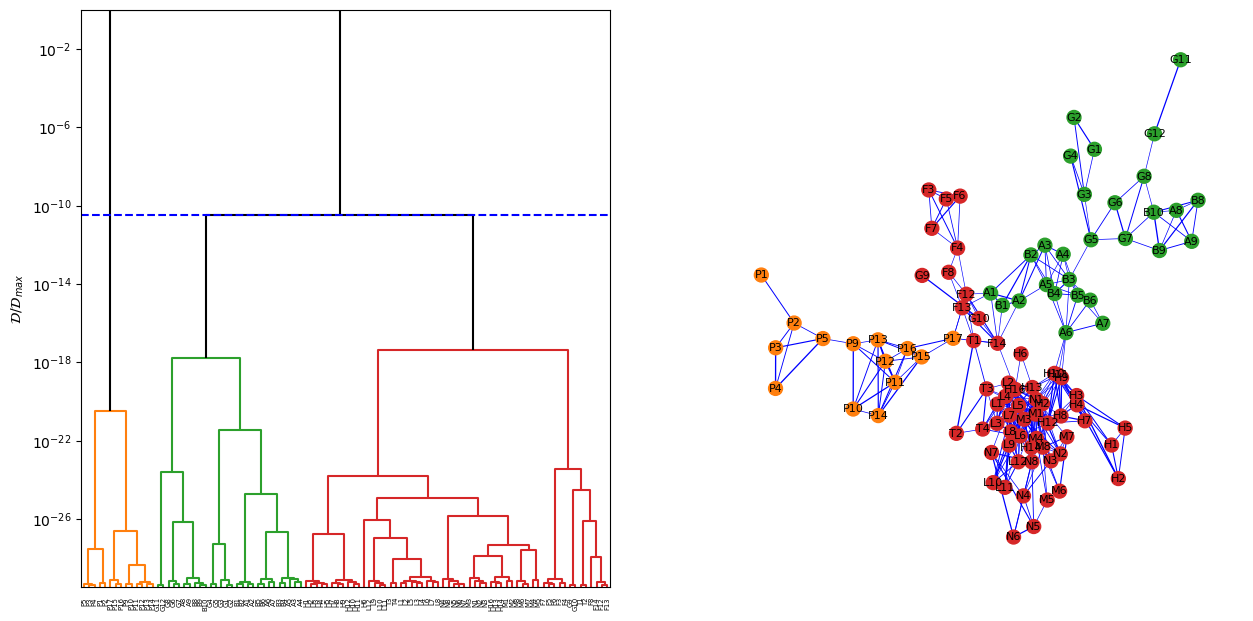

In [7]:
#
node_list = list(G.nodes())
labels_for_dendro = [label_dict[n] for n in node_list]
#
widths = [G[u][v]['weight'] for u, v in G.edges()]
edge_colors = ['r' if d['weight'] < 0 else 'b' for _,_,d in G.edges(data=True)]
#
fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))
# Dendrogram first (to get the leaf colors)
dendro = dendrogram(
    lnkgM,
    ax=ax[0],
    color_threshold=clTh,
    labels=labels_for_dendro,
    **kw_dentro
)
# Get the leaf colors from dendrogram and map to nodes
zip_llb_col = zip(dendro['ivl'], dendro['leaves_color_list'])
leaf_label_colors = {lbl: col for lbl, col in zip_llb_col}
node_colors = [leaf_label_colors[label_dict[n]] for n in G.nodes()]
#
tmin = lnkgM[:, 2][0] * 0.8
tmax = lnkgM[:, 2][-1] * 1.01
ax[0].set_yscale('log')
ax[0].axhline(clTh, **kw_thline)
ax[0].set_ylim(tmin, tmax)
ax[0].set_ylabel(r'$\mathcal{D}/\mathcal{D}_{max}$')
#
pos = nx.kamada_kawai_layout(G)
#
nx.draw(
    G, ax=ax[1],
    width=widths,
    edge_color=edge_colors, 
    labels=label_dict,
    node_color=node_colors,
    pos=pos,
    **kw_draw_graph
)

### multiple per phase and successive thresholds

In [9]:
n_jumps = 10  # Number of first jumps to analyze

In [ ]:
# Cycle through phases and jump thresholds - individual plots
for phase_idx, phase in enumerate(phase_labels):
    # Get data for this phase
    data_pat_phase = data_pat[phase]
    data_pat_phase_ts = data_pat_phase['data']
    fs = data_pat_phase['fs']
    # Build correlation network
    corr_mat = build_corr_network(
        data_pat_phase_ts,
        **correlation_protocol
    )
    Th, jumps = find_threshold_jumps(nx.from_numpy_array(corr_mat))
    for jump_idx in range(min(n_jumps, len(jumps))):
        str_fname_list = [patient, phase, f'jump{jump_idx:02d}', f'th{Th[jumps[jump_idx]]:.3f}']
        filename = f'{patient}_{phase}_jump{jump_idx:02d}_th{Th[jumps[jump_idx]]:.3f}.pdf'
        # Apply threshold
        corr_mat_tmp = corr_mat.copy()
        corr_mat_tmp[corr_mat_tmp < Th[jumps[jump_idx]]] = 0
        G, rnodes = get_giant_component_leftoff(nx.from_numpy_array(corr_mat_tmp))
        label_dict = {k: v for k, v in pin_labels.to_dict().items() if k not in rnodes}
        # Compute hierarchical clustering
        spect, L, rho, Trho, tau = compute_laplacian_properties(G, tau=None)
        dists = squareform(Trho)
        lnkgM, label_list, _ = compute_normalized_linkage(dists, G, method='ward')
        clTh, *_ = compute_optimal_threshold(lnkgM, scaling_factor=0.98)
        #
        node_list = list(G.nodes())
        labels_for_dendro = [label_dict[n] for n in node_list]
        widths = [G[u][v]['weight'] for u, v in G.edges()]
        edge_colors = ['r' if d['weight'] < 0 else 'b' for _,_,d in G.edges(data=True)]
# Create individual figure for this phase/threshold combination
        fig, ax = plt.subplots(figsize=(12, 6))
        # Dendrogram (left panel)
        dendro = dendrogram(
            lnkgM,
            ax=ax,
            color_threshold=clTh,
            labels=labels_for_dendro,
            **kw_dentro
        )
        # Create an inset axis inside the dendrogram axis (use lower-right corner)
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        inset_ax = inset_axes(ax, width="50%", height="50%", loc='upper right')
        # Get the leaf colors from dendrogram and map to nodes
        leaf_label_colors = {lbl: col for lbl, col in zip(dendro['ivl'], dendro['leaves_color_list'])}
        node_colors = [leaf_label_colors.get(label_dict[n], 'gray') for n in node_list]
        # Draw network inside the inset axis
        pos = nx.kamada_kawai_layout(G)
        nx.draw(G, ax=inset_ax, width=widths, edge_color=edge_colors,
                labels=label_dict,
                node_color=node_colors, pos=pos,
                node_size=80, font_size=6, with_labels=True)
        inset_ax.set_title(f'Network (N={len(G.nodes())})', fontsize=8)
        # Hide the separate right-hand axis (we use an inset instead)
        # Adjust dendrogram appearance
        tmin = lnkgM[:, 2][0] * 0.8
        tmax = lnkgM[:, 2][-1] * 1.01
        ax.set_yscale('log')
        ax.axhline(clTh, **kw_thline)
        ax.set_ylim(tmin, tmax)
        ax.set_ylabel(r'$\mathcal{D}/\mathcal{D}_{max}$')
        # Set overall title and save
        fig.suptitle(f'{patient} - {phase} - Jump {jump_idx} - Threshold {Th[jumps[jump_idx]]:.3f} - Nodes: {len(G.nodes())}', fontsize=14)
        fig.savefig(path_figs / filename, bbox_inches='tight')
        plt.close(fig)
print("All plots saved!")

All plots saved!


### multiple per phase, per band

#### helper functions

In [ ]:


def plot_dendrogram(ax, lnkgM, clTh, labeldict, node_list, phase):
    """Plot dendrogram on given axis."""
    labels_for_dendro = [labeldict[n] for n in node_list]
    
    dendro = dendrogram(
        lnkgM, ax=ax, color_threshold=clTh, labels=labels_for_dendro,
        above_threshold_color='k', leaf_font_size=6, orientation='top'
    )
    
    tmin, tmax = lnkgM[:, 2][0] * 0.8, lnkgM[:, 2][-1] * 1.01
    ax.set_yscale('log')
    ax.axhline(clTh, color='b', linestyle='--', alpha=0.7)
    ax.set_ylim(tmin, tmax)
    ax.set_ylabel(r'$\mathcal{D}/\mathcal{D}_{max}$')
    ax.set_title(f'{phase} - Dendrogram')
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    return dendro

def plot_network(ax, G_giant, labeldict, dendro, node_list, phase, node_count):
    """Plot network on given axis with colors matching dendrogram."""
    # Prepare edge properties
    widths = [G_giant[u][v]['weight'] for u, v in G_giant.edges()]
    edge_colors = ['red' if d['weight'] < 0 else 'blue' for u, v, d in G_giant.edges(data=True)]
    
    # Map node colors from dendrogram
    leaf_label_colors = {lbl: col for lbl, col in zip(dendro['ivl'], dendro['leaves_color_list'])}
    node_colors = [leaf_label_colors.get(labeldict[n], 'gray') for n in node_list]
    
    # Draw network
    pos = nx.kamada_kawai_layout(G_giant)
    nx.draw(G_giant, ax=ax, width=widths, edge_color=edge_colors,
            labels=labeldict, node_color=node_colors, pos=pos, 
            node_size=100, font_size=8, with_labels=True)
    ax.set_title(f'{phase} - Network (Nodes: {node_count})')

def handle_empty_phase(axes, phase_idx, phase, message="No nodes\nremaining"):
    """Handle empty network case by adding text to both axes."""
    for col in [0, 1]:
        axes[phase_idx, col].text(0.5, 0.5, message, ha='center', va='center', 
                                  transform=axes[phase_idx, col].transAxes)
        title_suffix = "Dendrogram" if col == 0 else "Network"
        axes[phase_idx, col].set_title(f'{phase} - {title_suffix}')


#### run analysis

    rsPre: 112 nodes in giant component
  Processing phase: taskLearn


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    taskLearn: 112 nodes in giant component
  Processing phase: taskTest


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    taskTest: 112 nodes in giant component
  Processing phase: rsPost


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/src/lrg_eegfc/utils/corrmat.py:351: UserWarning: Band 'delta': Expected 2 connected components (jump_index=1) but found 3 components. Network topology may be unexpected at threshold 0.436421.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/src/lrg_eegfc/utils/corrmat.py:351: UserWarning: Band 'delta': Expected 2 connected components (jump_index=1) but found 3 components. Network topology may be unexp

    rsPost: 106 nodes in giant component
  Saved: Pat_02_beta_cross_phase_jump01.pdf
  Saved: Pat_02_beta_cross_phase_jump01.pdf


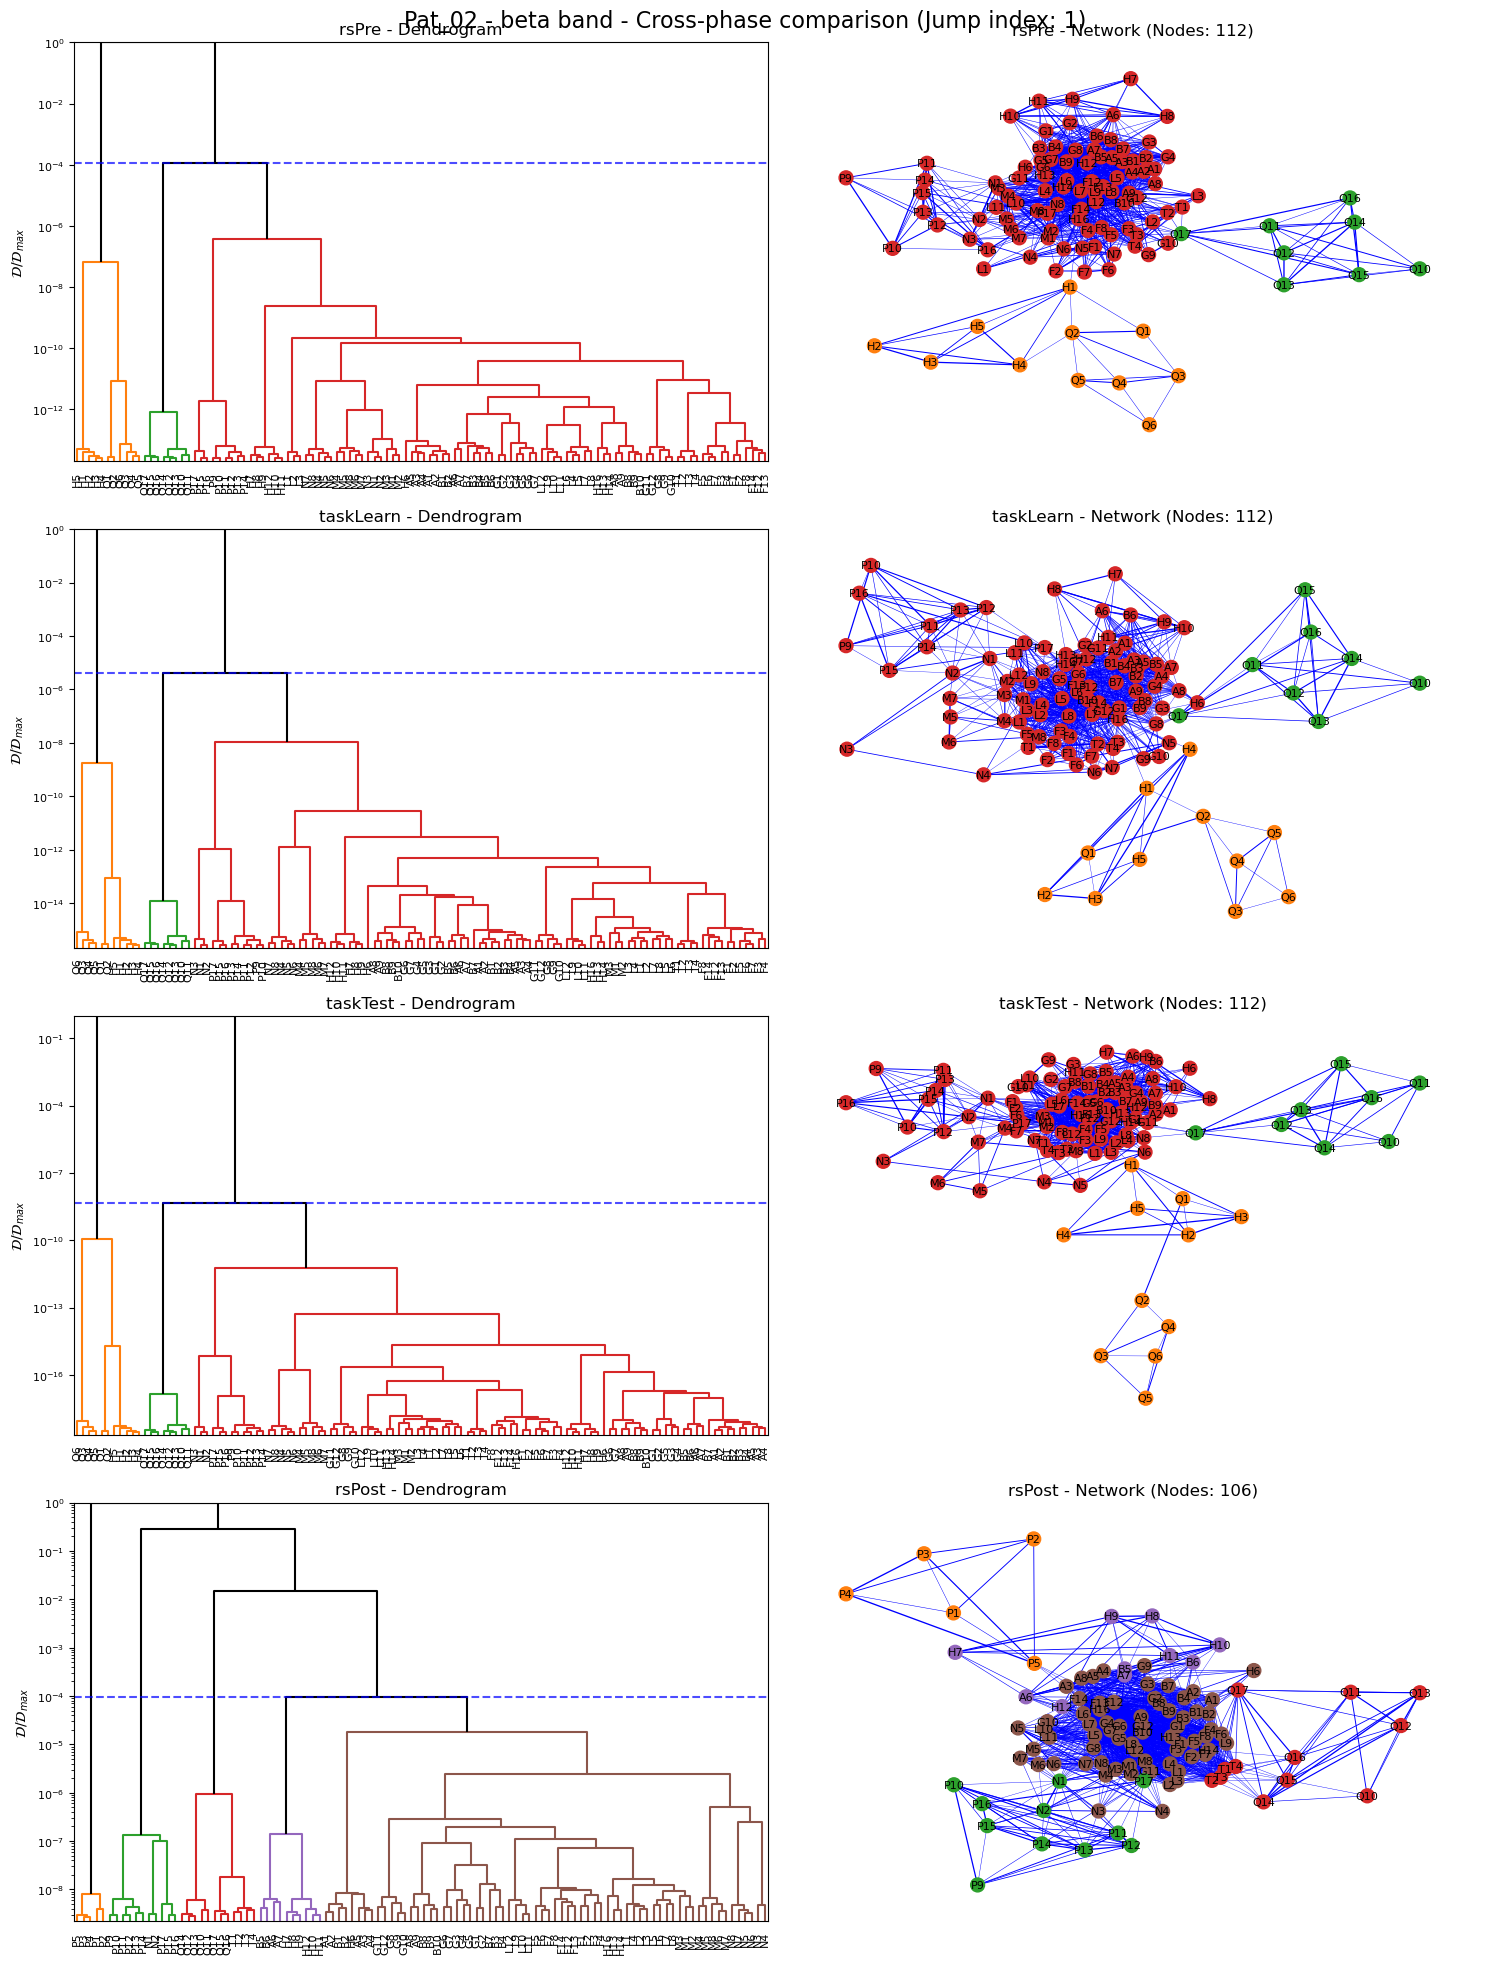


Processing band: low_gamma
  Processing phase: rsPre


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    rsPre: 112 nodes in giant component
  Processing phase: taskLearn


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    taskLearn: 112 nodes in giant component
  Processing phase: taskTest


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    taskTest: 112 nodes in giant component
  Processing phase: rsPost


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/src/lrg_eegfc/utils/corrmat.py:351: UserWarning: Band 'delta': Expected 2 connected components (jump_index=1) but found 3 components. Network topology may be unexpected at threshold 0.436421.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/src/lrg_eegfc/utils/corrmat.py:351: UserWarning: Band 'delta': Expected 2 connected components (jump_index=1) but found 3 components. Network topology may be unexp

    rsPost: 112 nodes in giant component
  Saved: Pat_02_low_gamma_cross_phase_jump01.pdf
  Saved: Pat_02_low_gamma_cross_phase_jump01.pdf


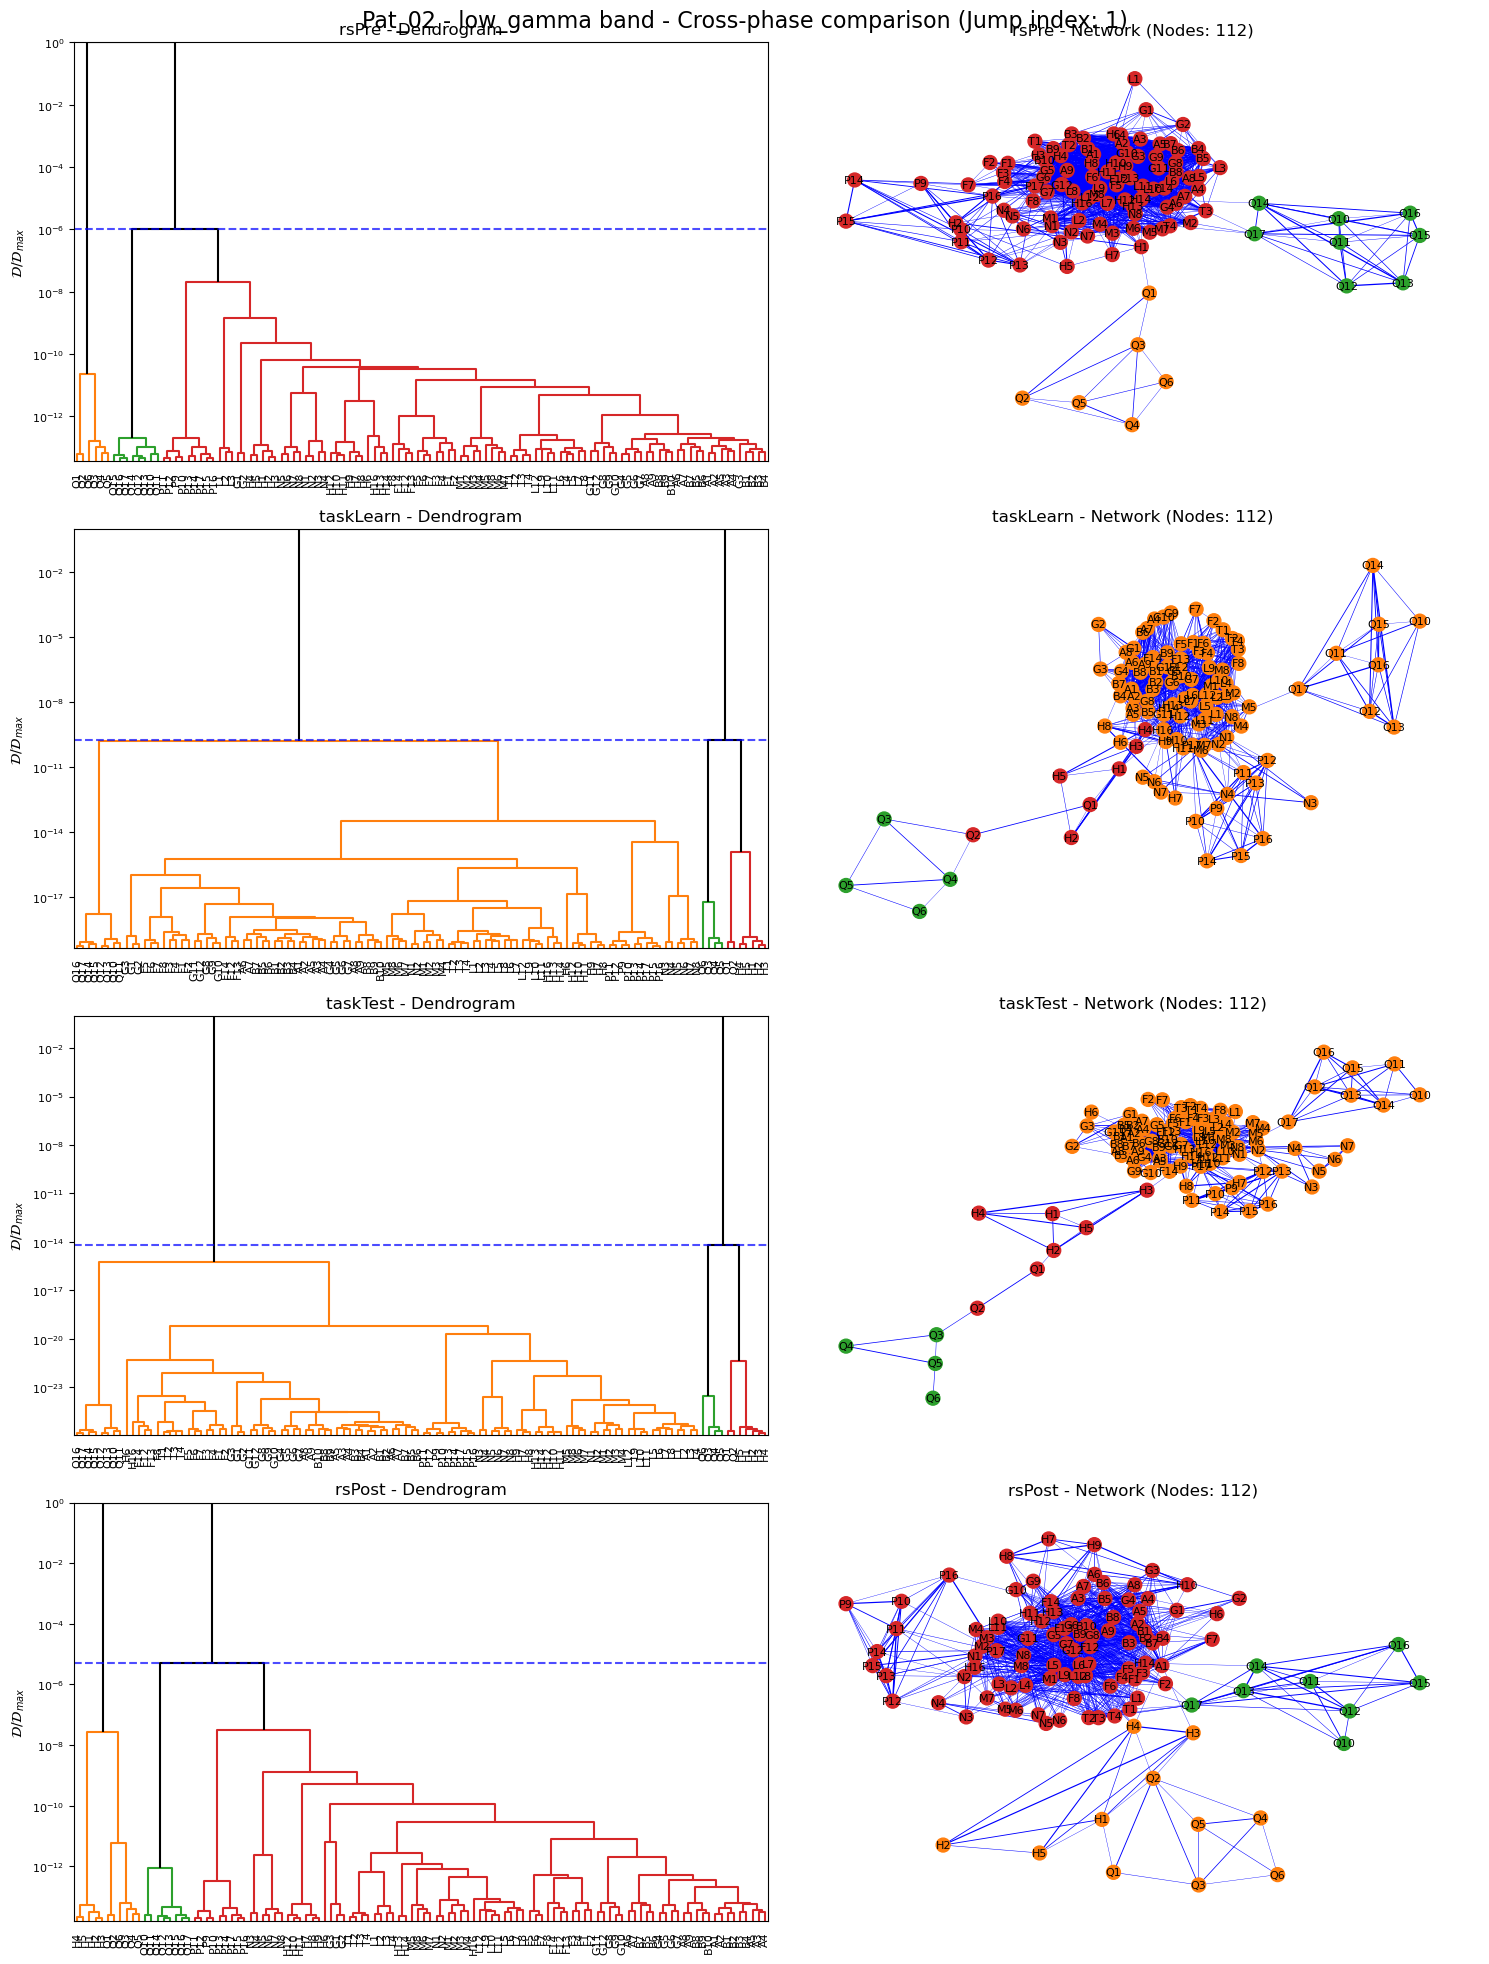


Processing band: high_gamma
  Processing phase: rsPre


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    rsPre: 111 nodes in giant component
  Processing phase: taskLearn


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    taskLearn: 111 nodes in giant component
  Processing phase: taskTest


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    taskTest: 111 nodes in giant component
  Processing phase: rsPost


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/src/lrg_eegfc/utils/corrmat.py:351: UserWarning: Band 'delta': Expected 2 connected components (jump_index=1) but found 3 components. Network topology may be unexpected at threshold 0.436421.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/src/lrg_eegfc/utils/corrmat.py:351: UserWarning: Band 'delta': Expected 2 connected components (jump_index=1) but found 3 components. Network topology may be unexp

    rsPost: 111 nodes in giant component
  Saved: Pat_02_high_gamma_cross_phase_jump01.pdf
  Saved: Pat_02_high_gamma_cross_phase_jump01.pdf


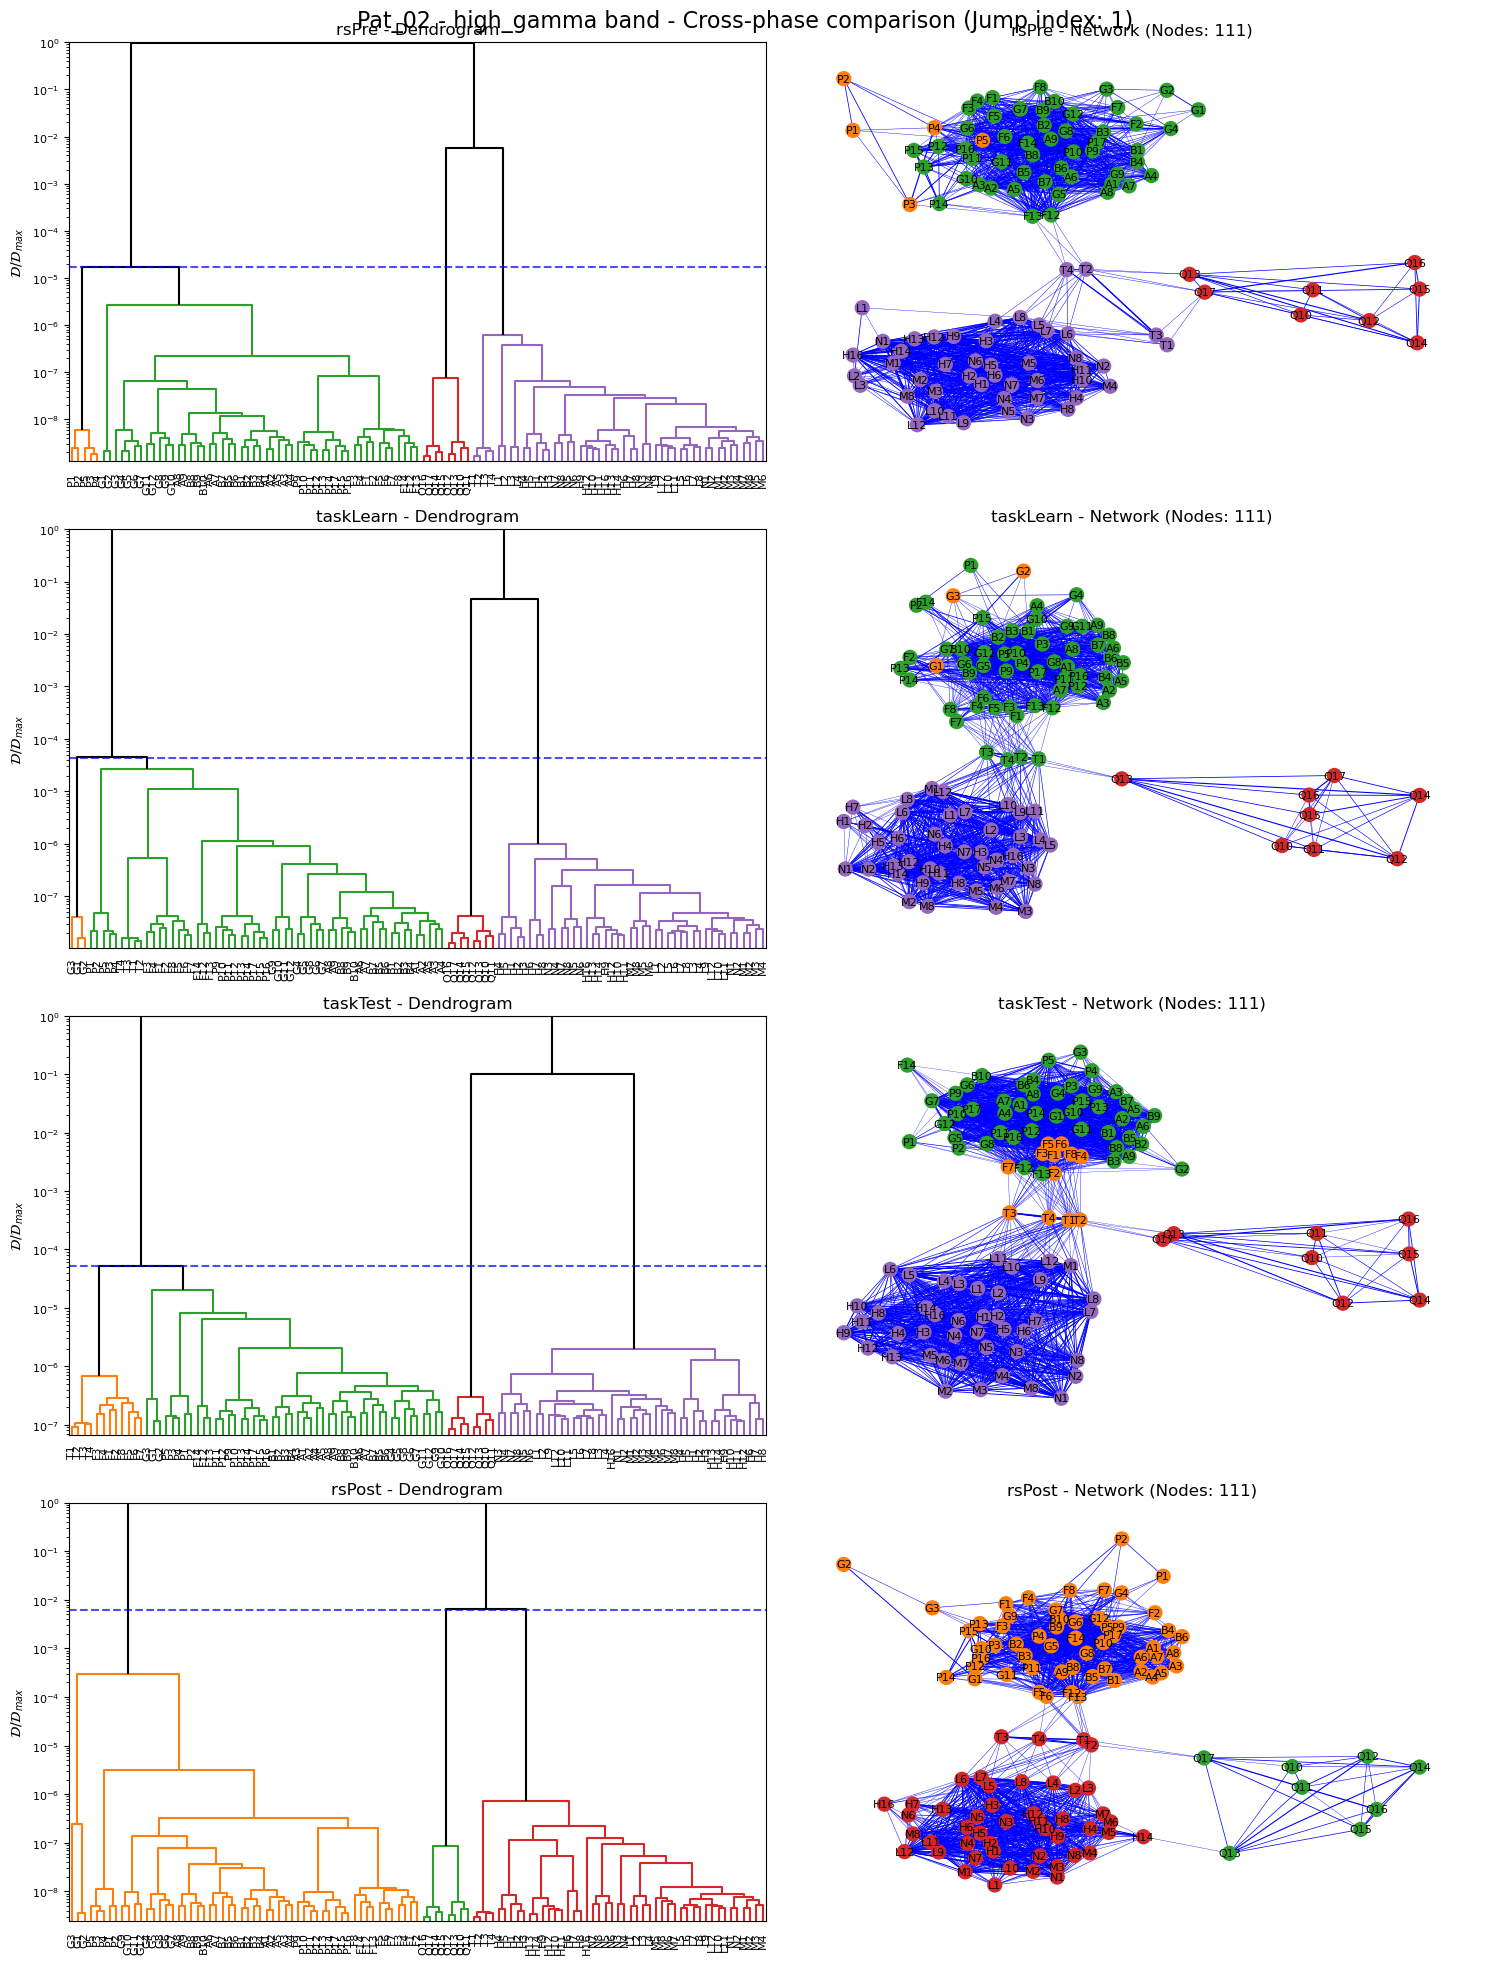


All band-phase grid plots completed!


In [ ]:

# Main analysis loop
jump_index_to_use = 1

for band_name in BRAIN_BANDS.keys():
    print(f"\nProcessing band: {band_name}")
    # Create figure
    fig, axes = plt.subplots(len(phase_labels), 2, figsize=(15, 5*len(phase_labels)))
    if len(phase_labels) == 1:
        axes = axes.reshape(1, -1)
    
    for phase_idx, phase in enumerate(phase_labels):
        print(f"  Processing phase: {phase}")
        
        # Get phase data
        data_pat_phase = data_pat[phase]
        data_pat_phase_ts, fs = data_pat_phase['data'], data_pat_phase['fs']
        
        # Process network
        result = process_network_for_phase(
            data_pat_phase_ts, fs, band_name, correlation_protocol, 
            jump_index_to_use, pin_labels
        )
        G_giant, label_dict, lnkgM, clTh, corr_mat = result
        
        # Handle empty networks
        if G_giant is None:
            message = 'No giant\ncomponent' if label_dict is None else 'No nodes\nremaining'
            handle_empty_phase(axes, phase_idx, phase, message)
            continue
        
        node_list = list(G_giant.nodes())
        
        # Plot dendrogram and network
        dendro = plot_dendrogram(axes[phase_idx, 0], lnkgM, clTh, label_dict, node_list, phase)
        plot_network(axes[phase_idx, 1], G_giant, label_dict, dendro, node_list, phase, G_giant.number_of_nodes())
        
        print(f"    {phase}: {G_giant.number_of_nodes()} nodes in giant component")
    
    # Finalize figure
    fig.suptitle(f'{patient} - {band_name} band - Cross-phase comparison (Jump index: {jump_index_to_use})', fontsize=16)
    plt.tight_layout()
    
    # Save and display
    filename = f'{patient}_{band_name}_cross_phase_jump{jump_index_to_use:02d}.pdf'
    fig.savefig(path_figs / filename, bbox_inches='tight')
    print(f"  Saved: {filename}")
    plt.show()

print("\nAll band-phase grid plots completed!")